# Chapter 8 - Conservation of energy

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

## Dissipation-driven melting and compaction

The thickness of the layer of ice is the solution of equations

\begin{align}
\label{eq:cmp-diss-mech-odes-nondim-a}
\dot{\layerthick} &= -\cmpdisspar\layerthick\por,\\
\label{eq:cmp-diss-mech-odes-nondim-b}
\dot{\por} &= \e^{-\lambda\por} - \cmpdisspar\omp\por,
\end{align}

where $\Pi$, the *compaction-dissipation number*, is given by 

\begin{equation*}
  \cmpdisspar\equiv\frac{\density\sol\latent\layerstress\layerthick_0^2}
  {\eta_0^2\layershear_0^2},
\end{equation*}

The Python code below implements the right-hand side of equations \eqref{eq:cmp-diss-mech-odes-nondim-a} and \eqref{eq:cmp-diss-mech-odes-nondim-b}, which will be soon solved numerically.

In [2]:
def thick(y, t, pi, lam):  # y = [H, phi]
    H = y[0]
    phi = y[1]
    return [-pi * H * phi, np.exp(-lam*phi) - pi * (1. - phi) * phi]

The figure below plots the layer thickness $\mathcal{H}$ relative to initial versus time for three values of $\Pi$.

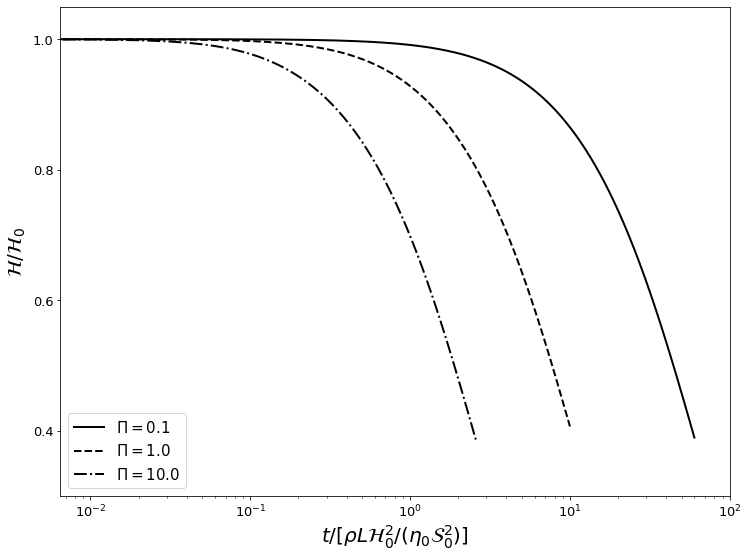

In [3]:
f, ax = plt.subplots()
f.set_size_inches(12.0, 9.0)

y0 = [1., 0.0]  # initial condition: H=1, phi=0.0
lambda_ = 27.0
Pi = np.asarray([0.1, 1., 10.])
tmax = np.asarray([60., 10., 2.6])
linesty = ['-', '--', '-.']
for tm, pi, ls in zip(tmax, Pi, linesty):
    t = np.arange(0.0, tm, 0.01)
    S = odeint(thick, y0, t, args=(pi, lambda_), rtol=1e-8)
    ax.semilogx(t, S[:, 0], 'k', linestyle=ls, linewidth=2, label=f'$\Pi={str(pi)}$')

ax.set_xlabel(r'$t/[\rho L\mathcal{H}_0^2/(\eta_0\mathcal{S}_0^2)]$', fontsize=20)
ax.set_xticks((1e-2, 1e-1, 1e0, 1e1, 1e2))
ax.set_ylim(0.3, 1.05)
ax.set_ylabel(r'$\mathcal{H}/\mathcal{H}_0$', fontsize=20)
ax.set_yticks((0.4, 0.6, 0.8, 1.0))
ax.legend(loc='lower left', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

The figure below plots porosity versus time for three values of $\Pi$.

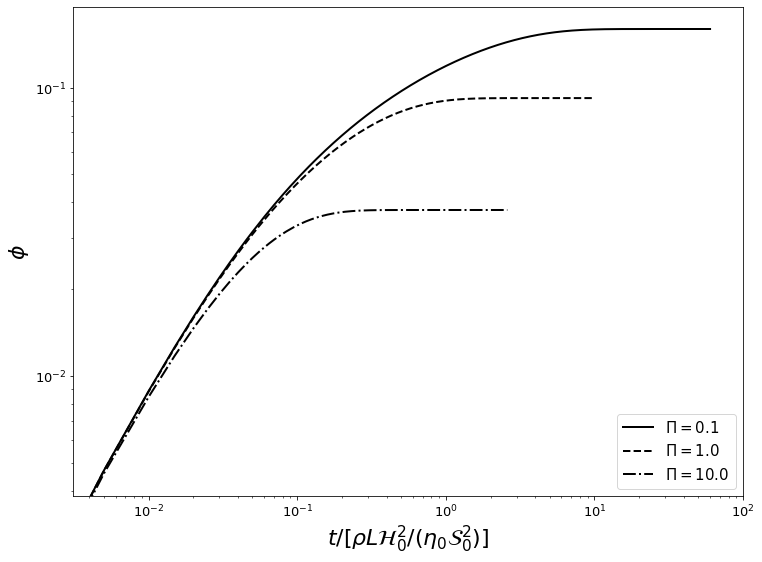

In [4]:
f, ax = plt.subplots()
f.set_size_inches(12.0, 9.0)

y0 = [1., 0.0]  # initial condition: H=1, phi=0.0
lambda_ = 27.0
Pi = np.asarray([0.1, 1., 10.])
tmax = np.asarray([60., 10., 2.6])
linesty = ['-', '--', '-.']
for pi, tm, ls in zip(Pi, tmax, linesty):
    t = np.arange(0.0, tm, 0.005)
    S = odeint(thick, y0, t, args=(pi, lambda_), rtol=1e-8)
    ax.loglog(t, S[:, 1], 'k', linestyle=ls, linewidth=2, label=f'$\Pi={str(pi)}$')

ax.set_xlabel(r'$t/[\rho L\mathcal{H}_0^2/(\eta_0\mathcal{S}_0^2)]$', fontsize=22)
ax.set_xticks((1e-2, 1e-1, 1e0, 1e1, 1e2))
ax.set_ylabel(r'$\phi$', fontsize=22)
ax.set_yticks((1e-2, 1e-1))
ax.legend(loc='lower right', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.show()

## Decompression melting

At depths greater than the onset of decompression melting we have
\begin{equation}
  \label{eq:decomp-melting-subsolidus}
  \diff{\temp}{z} = - \frac{\expansivity g \temp}{\heatcapacity},
\end{equation}
while within the melting region the isentrope is given by
\begin{equation}
  \label{eq:decomp-melting-meltregion}
  \diff{\temp}{z} = -\frac{\expansivity\temp g/\heatcapacity + 
    \density g/\clapeyron}{1 + \latent\dFdT/\heatcapacity}.
\end{equation}

The Python code below implements the right-hand side of equations \eqref{eq:decomp-melting-subsolidus} and \eqref{eq:decomp-melting-meltregion}, which will be soon solved numerically.

In [5]:
def TemperatureEquation(T, z, Ts0, rho, g, C, alpha, L, M):  # y = T, args=(Ts0, rho, g, C, alpha, L, M)
    Tsol = Ts0 - rho*g*z/C
    return -(alpha*T*g/c + rho*g/C)/(1 + L*M/c) if T > Tsol else -alpha*T*g/c

The following constants are defined:

In [6]:
c = 1200.  # heat capacity
alpha = 3e-5  # expansivity
rho = 3000.  # density
g = 10.  # gravity
L = 5e5  # latent heat J/kg
M = 1/500  # isobaric productivity
C = 6.5e6  # clapeyron Pa/K
Ts0 = 1100. + 273.  # solidus at P=0
Tp = 1350. + 273.  # mantle potential temperature

Figure below plots the decompression melting curves with no melt segregation. Temperature as a function of $z$. The solid curve shows the isentropic temperature profile (the \textit{isentrope}) computed according to eqns. \eqref{eq:decomp-melting-subsolidus} and \eqref{eq:decomp-melting-meltregion}. The dashed line shows the isentrope for no melting. Dotted lines are isopleths of the degree of melting $F$.

In [7]:
zF = - (Tp-Ts0)/(rho*g/C - alpha*g*Tp/c)  # metres
zmax = -100.*1000.
Tmax = Tp*np.exp(-alpha*g*zmax/c)

z = np.linspace(zmax, 0., 5000)
T = odeint(TemperatureEquation, Tmax, z, args=(Ts0, rho, g, C, alpha, L, M))
Tsol = Ts0 - rho*g*z/C

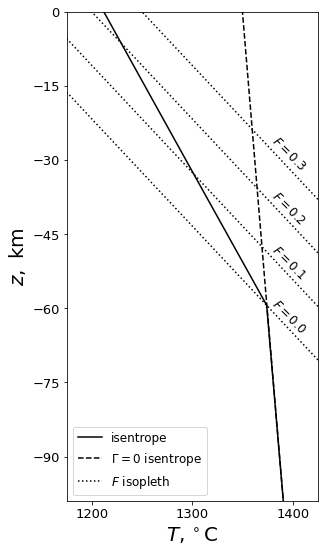

In [8]:
f, ax = plt.subplots()
f.set_size_inches(4.5, 9.0)

l1 = ax.plot(T-273., z/1000., '-k')[0]
l2 = ax.plot(Tp * np.exp(-alpha*g*z/c) - 273., z/1000., '--k')[0]
for i in [0.0, 0.1, 0.2, 0.3]:
    l3 = ax.plot(Tsol - 273. + i/M, z/1000., ':k')[0]
    ax.text(1415, -65+i*110, f'$F={str(i)}$', fontsize=12, rotation=-45, horizontalalignment='right')

ax.set_xlabel(r'$T, ^\circ$C', fontsize=20)
ax.set_xticks((1200, 1300, 1400))
ax.set_xlim(1175, 1425)
ax.set_ylabel(r'$z,$ km', fontsize=20)
ax.set_yticks(np.arange(-90., 1., 15))
ax.set_ylim(-99., 0.0)
ax.legend(handles=[l1, l2, l3], 
          labels=['isentrope', '$\Gamma=0$ isentrope', '$F$ isopleth'], 
          loc='lower left', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.show()

Next figure plots the degree of melting associated with the isentrope in figure above.

In [9]:
zF = - (Tp-Ts0)/(rho*g/C - alpha*g*Tp/c)  # metres
zmax = -100.*1000.
Tmax = Tp*np.exp(-alpha*g*zmax/c)

z = np.linspace(zmax, 0., 5000)
T = odeint(TemperatureEquation, Tmax, z, args=(Ts0, rho, g, C, alpha, L, M))

Tsol = Ts0 - rho*g*z/C
F = np.maximum(M * (T[:, 0] - Tsol), 0.0)

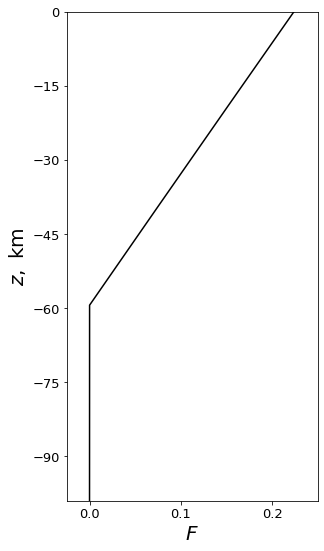

In [10]:
f, ax = plt.subplots()
f.set_size_inches(4.5, 9.0)

ax.plot(F, z/1000, '-k')
ax.set_xlabel(r'$F$', fontsize=20)
ax.set_xticks((0.0, 0.1, 0.2, 0.3, 0.4, 0.5))
ax.set_xlim(-0.025, 0.25)
ax.set_ylabel(r'$z,$ km', fontsize=20)
ax.set_yticks(np.arange(-90., 1., 15))
ax.set_ylim(-99., 0.0)
ax.tick_params(axis='both', which='major', labelsize=13)

plt.show()